In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import h5py
import glob
import shutil
import sys
import os
import os.path
import subprocess
import pickle
from shutil import copyfile

from collections import OrderedDict


#sys.path.append('/opt/rtcds/userapps/release/tcs/common/scripts/hws_tools/')
sys.path.append('/ligo/home/daniel.brown/git/hws-binaries/HWS/')

from HS_Image import HS_Image
from HS_Centroids import HS_Centroids
from HS_Gradients import HS_Gradients
from HS_WFP import HS_WFP
from HS_Export import HS_Export
import HSM_WFN

import pyctrl
if not os.path.exists('data'):
    os.makedirs('data')

In [2]:
"""
HWS Utility Tools

This is a collection of tools for interacting with the Hartmann wavefront sensors.
This mostly functions for getting and plotting data.
"""


try:
    FileNotFoundError
except NameError:
    FileNotFoundError = IOError

def caget(channel):
    rtn = subprocess.check_output(['caget', '-g', '15', channel])
    return rtn.split()[-1]

def getFileGPSTimes(fList):
    """
    For a list of HWS file names this extracts the GPS times
    from the file names and returns them as a list
    
    Parameters
    ==========
    flist : list
        List of paths to HWS files
    
    Returns
    =======
    GPS times, np.array[int]
    """
    gpstimeList = []
    for f in fList:
        gpstimeList.append(int(os.path.basename(f).split('_')[0]))
    return np.array(gpstimeList, dtype=np.int)


def date_2_gps(date):
    """
    Calls the gpstime command line tool to convert a date string
    into GPS time

    Returns
    =======
    GPS time, float

    Example
    =======
    date_2_gps('2018-11-01 17:36:55.549957 UTC')
    # Returns 1225129033.55
    """
    rtn = subprocess.check_output(['gpstime', date])
    return float(rtn.split("GPS:")[-1].strip())


def gps_2_date(date):
    """
    Calls the gpstime command line tool to convert a gps time
    into UTC date

    Returns
    =======
    Date, datestring
    """
    rtn = subprocess.check_output(['gpstime', date])
    return float(rtn.split("GPS:")[-1].strip())

def any_2_gps(date_or_gps):
    """
    Always returns a GPS time. If a date is entered then
    date_2_gps is called to convert it.
    
    Returns
    =======
    GPS time, float
    """
    try:
        gps = float(date_or_gps)
    except ValueError:
        gps = date_2_gps(date_or_gps)
    
    return gps


def _look_for_data_dir():
    """
    Looks for some default directories that are L1 and H1 specific
    where HWS data is stored.

    Returns
    =======
    Path to HWS data : str
    """

    ifo = os.environ['IFO']

    if ifo == 'H1':
        if os.path.exists('/h1hwsmsr/data'):
            data_dir = '/h1hwsmsr/data'
        elif os.path.exists('/data'):
            data_dir = '/data'
        else:
            raise FileNotFoundError("Could not find default data directory")
    elif ifo == 'L1':
        raise Exception("TODO, check LLO storage locations")
    else:
        raise Exception("Unexpected IFO input `{}`, should be H1 or L1".format(ifo))

    return data_dir


def get_servers(ifo=None):
    """
    This function returns the HWS servers that are running at
    the site. By default it will return the servers for the
    current site you run it at.

    Parameters
    ----------
    ifo : str, optional
        Interferometer name, either H1 or L1. When set to None it
        tried to read the $IFO environment variable
   
    Returns
    -------
    Dict of servers: dict(optic:(server, port))
    """
    if ifo is None:
        if 'IFO' not in os.environ:
            raise Exception("IFO environment variable is not set")
        else:
            ifo = os.getenv('IFO')


    if ifo == 'H1':
        return    {
                    'ITMX': ('h1hwsmsr', 9991),
                    'ITMY': ('h1hwsmsr1', 9991),
                    'ETMX': ('h1hwsex', 9991),
                    'ETMY': ('h1hwsey', 9991),
                  }
    elif ifo == 'L1':
        # Are these right for L1????
        return    {
                    'ITMX': ('l1hwsmsr', 9991),
                    'ITMY': ('l1hwsmsr1', 9991),
                    'ETMX': ('l1hwsex', 9991),
                    'ETMY': ('l1hwsey', 9991),
                  }
    else:
        raise Exception("Argument {} is not L1 or H1".format(ifo))


def get_file(time, dtime=60, optic='ITMX', data_dir=None, ifo=None,  extension='.hdf5'):
    """
    Searchs for a HWS file at a certain GPS time or date.

    Parameters
    ==========
    time : int or str
        GPS time or date to search for
    dtime : int, optional
        Bound to search within in seconds from time
    data_dir : str, optional
        Top level data storage directory
    ifo : str, optional
        Interferometer, H1 or L1
    optic : str, optional
        The choice of optic to look at, ITMX, ETMX, ITMY, ETMY
    extension : str, optional
        Type of file to look for
        
    Returns
    =======
    GPS time, file names, tuple
    """
    if ifo is None:
        ifo = os.environ['IFO']
    
    assert(ifo in ['H1','L1'])
    
    if data_dir is None:
        data_dir = _look_for_data_dir()
        
    data_dir = os.path.join(data_dir, ifo, optic+"_HWS/")
    t0       = any_2_gps(time)
    fileList = []
    
    # Search in nearest time folders just in case 
    for i in [-1,0,1]:
        tSTEM = str(int(np.floor(t0/1E5)) + i) + '00000'
        fileTemplate = os.path.join(data_dir, tSTEM, '*' + extension)
        fileList.extend( glob.glob(fileTemplate) )

    if len(fileList) == 0: raise FileNotFoundError("No files for time {} +- {} seconds".format(time, dtime))
    fileList = np.array(fileList)
    
    # find the closest file to input file time
    fileTimes   = np.array( getFileGPSTimes(fileList) )
    idx = abs(fileTimes-time).argmin()
    
    return fileTimes[idx], fileList[idx]


def get_files(start, end, optic='ITMX', data_dir=None, ifo=None, extension='.hdf5', dtime=60):
    """
    Gets all the HWS files between two GPS times. Can be customised
    to run at different sites and storage locations

    Parameters
    ==========
    start : int or str
        Start GPS time or date
    end : int or str
        End GPS time or date
    optic : str, optional
        The choice of optic to look at, ITMX, ETMX, ITMY, ETMY
    ifo : str, optional
        Interferometer, H1 or L1. If none provided it will use the $IFO environment variable
    data_dir : str, optional
        Top level data storage directory. If None then it will guess some likely options:
            H1, 1) /h1hwsmsr/data
            H1, 2) /data
            L1, 1) ???? 
    dtime : int, optional
        Search within this time bound of start and end for a file
        
    Returns
    =======
    Dictionary of GPS times and file names, key: GPS times, value: filename
    """
    if ifo is None:
        ifo = os.environ['IFO']
    
    assert(ifo in ['H1','L1'])
    
    if data_dir is None:
        data_dir = _look_for_data_dir()
        
    HWStimes = OrderedDict()
    data_dir = os.path.join(data_dir, ifo, optic+"_HWS/")
    start_gps = any_2_gps(start)
    end_gps   = any_2_gps(end)
    
    # We need to get all files between two times, so we may have to check multiple folders
    start_folder = int(np.round(start_gps/1e5))
    end_folder   = int(np.round(end_gps/1e5)  )
    dfold = end_folder - start_folder
    
    fileList = []
    
    for i in list(range(int(start_folder)-1, int(end_folder)+2)):
        tSTEM = str(i*100000)
        fileTemplate = os.path.join(data_dir, tSTEM, '*' + extension)
        fileList.extend( glob.glob(fileTemplate) )

    fileList = np.array(fileList)
    if len(fileList) == 0:
        raise FileNotFoundError("No HWS files found between {} and {} (ext={})".format(int(start), int(end), extension))

    # find the closest file to input file time
    fileTimes = np.array( getFileGPSTimes(fileList) )
    idx       = np.array(np.logical_and(fileTimes>=(start_gps-dtime), fileTimes<=(end_gps+dtime)))
    
    if len(fileTimes[idx]) == 0:
        raise FileNotFoundError("No HWS files found between {} and {} (ext={})".format(int(start), int(end), extension))
        
    return OrderedDict(sorted(zip(fileTimes[idx], fileList[idx])))


def copy_files(destination, start, end, *args, **kwargs):
    """
    Copies HWS files from a data directory to some storage location
    
    Parameters
    ==========
    destination : str
        Path to copy files to
    start : int or str
        Start GPS time or date
    end : int or str
        End GPS time or date
    data_dir : str
        Top level data storage directory
    ifo : str
        Interferometer, H1 or L1
    optic : str
        The choice of optic to look at, ITMX, ETMX, ITMY, ETMY
    dtime : int, optional
        Search within this time bound of start and end times for files
        
    Returns
    =======
    Dict(GPS times: copied files)
    """
    if not os.path.exists(destination):
        os.mkdir(destination)
        
    files = get_hws_files(start, end, *args, **kwargs)
    
    new_files = []
    
    for f in files.values():
        shutil.copy(f, destination)
        new_files.append( os.path.join(destination, os.path.basename(f)) )
    
    return OrderedDict(sorted(zip(files.keys(), new_files)))


def open_file(filename):
    """
    Opens a HWS file. Handles different extensions depending on storage format.
    This is either a pickle file for old storage or HDF5 for the new storage
    format. Either way this returns a `HS_Export` object to be used.

    Parameters
    ==========
    filename : str
        Path and filename to a HWS file

    Returns
    =======
    Loaded data : HS_Export
    """
    ext = os.path.splitext(filename)[1]
    
    if ext == '.p':
        # Stupid hack to get around the fact HWS is now packaged
        # instead of separate scripts
        remove = False
        if 'HS_Export' not in sys.modules:
            remove = True
            sys.modules['HS_Export'] = HWS.HS_Export
        data = pickle.load(open(filename, 'rb'))
        if remove: del sys.modules['HS_Export']
        return data 
    elif ext == '.hdf5':
        
        data = h5py.File(filename, 'r')
        
        exp = HS_Export()
        exp.avGradients = data['avGradients'].value
        exp.avImage = data['avImage'].value

        for attr in data['avGradients'].attrs.keys():
            setattr(exp, attr, data['avGradients'].attrs[attr])

        return exp
    else:
        raise Exception("Unhandled extension")


def get_bad_pixel_file(optic):
    data_dir = _look_for_data_dir()
    ifo = os.environ['IFO']
    fname = os.path.join(data_dir, ifo, "BAD_PIXELS", optic + ".npy")
    print(fname)
    if os.path.exists(fname):
        return fname
    else:
        return None


def get_centroids(image, ref_centroids=None, bad_pixels=None, background_level=50,
                    mask_center=None, mask_radius=None):
    """
    Takes an image and processes it to extract the centroids in it.
    This is the first step in computing any Hartman analysis of an image.
    If the image being referenced to another then the `ref_centroids` object
    should be provided so that the same number of centroids are computed.
    
    This code is based on the processing that is done in the `State_3.py` 
    of the LIGO HWS analysis.

    This code does all the image processing such as removing bad pixels
    and setting circular masks if specified.
    
    Parameters
    ==========
    image : np.array
        Camera image to process
    ref_centroids : HS_Centroids
        Reference centroids to use for extracting centroids from `image`
    bad_pixels : np.array[array]
        This is a special bad pixel array object that contains an element]
        called `coords` which lists each bad pixel location.
    background_level : int
        Sets the background level of the image for processing centroids.
        50 is the default level set in `State_3.py` in the HWS code.
    mask_center : np.array[array, ndim=1, size=2]
        Set center of the mask
    mask_radius : int
        Mask radius in pixels

    Returns
    =======
    Centroids : HS_Centroids
    """
    hsi = HS_Image()
    hsi.original_image = image.astype(np.int)
    hsi.background = background_level

    if bad_pixels is not None:
        bad_pix_array = np.load(bad_pixels)
        hsi.bad_pixels = bad_pix_array.item(0)['coords']
        hsi.to_fix_bad_pixels=True

    if mask_radius is not None and mask_center is not None:
        hsi.to_mask_image = True
        hsi.mask_center = mask_center
        hsi.mask_radius = mask_radius
    
    hsi.process_image()

    hsc = HS_Centroids()
    hsc.hsimage = hsi
    
    if ref_centroids is None:
        hsc.find_centroids_from_image()
    else:
        hsc.find_centroids_using_template(ref_centroids.centroids)
    
    return hsc


def get_gradients(ref_centroids, centroids, origin=[511.5, 511.5], magnification=17.5, lever_arm=0.01):
    """
    Compares two sets of centroids to compute the gradients
    between them.

    This

    Parameters
    ==========
    ref_centroids : HS_Centroids
        Reference centroids
    centroids : HS_Centroids
        Centroids being analysed
    origin : np.array[float, shape=(2,)]
        The origin of the system relative to the (0,0) pixel of
        the camera sensor.
    magnification : float
        Magnification of the HWS optical system, e.g. `caget H1:TCS-ETMX_HWS_MAGNIFICATION`
    lever_arm : float
        Lever arm of the HWS system, e.g. `caget H1:TCS-ETMX_HWS_LEVER_ARM`
    
    Returns
    =======
    Gradients : HS_Gradients
    """
    hsg = HS_Gradients(ref_centroids, centroids)
    hsg.lever_arm = lever_arm
    hsg.magnification = magnification
    hsg.origin = np.array(origin, dtype=np.float64)
    hsg.construct_gradients()
    return hsg


def get_seidel(gradients):
    """
    Given a set of gradients this will compute the
    Seidel coefficients.

    Parameters
    ==========
    gradients : HS_Gradients

    Returns
    =======
    Seidel Coefficients : dict
    """
    hswfp = HS_WFP(gradients, order=6)
    hswfp.compute_poly_coeffs()
    hswfp.compute_seidel_coeffs()    
    return hswfp.seidel_coeffs
    
    
def get_optical_depth(start_gradients, final_gradients, magnification=17.5, N=100):
    """
    Computes the wavefront aberration that ocurred between two sets
    of Hartman gradients. It returns the wavefront aberration in
    terms of optical depth in nanometers.
    
    Parameters
    ==========
    start_gradients : HS_Gradients
        Gradients at some initial reference time
    final_gradients : HS_Gradients
        Gradients at a final time
    magnification : float
        Magnification of the HWS optical system, e.g. `caget H1:TCS-ETMX_HWS_MAGNIFICATION`
    N : int
        Generate an NxN wavefront aberration array
        
    Returns
    =======
    Optical depth in nanometers : np.array[float64]
    x, actual units on mirror : np.array[float]
    y, actual units on mirror : np.array[float]
    """
    hrg = start_gradients.gradients
    hsg = final_gradients.gradients
    
    pixel_size = 12e-6
    pixel_number = 1024

    rng = pixel_size * pixel_number * magnification/2
    
    limits = {'x': [-rng, rng],
              'y': [-rng, rng]}
    spc = 2*rng/N
    x_g, y_g = HSM_WFN.setup_grid(limits, spc)

    U = hsg[:,0] - hrg[:,0]
    V = hsg[:,1] - hrg[:,1]
    
    U = U - np.mean(U)   # remove tilt
    V = V - np.mean(V)
    
    cents = hsg[:,2:4]
    grads = np.transpose( np.array([U,V]) )

    # calculate the wavefront
    wf = -1E9 * HSM_WFN.calculate_wf(cents, grads, limits, spc)
    return wf, x_g, y_g, U, V




def get_hws_data(opt, ref_t, tar_t, bp, mask_c=None, mask_r=None, origin=[511.5, 511.5]):
    
    file_dict= get_files(ref_t,
                        tar_t,
                        optic=opt, 
                        data_dir=None, 
                        ifo=None,  
                        extension='.hdf5')
    fname0 = file_dict.items()[0][1]
    fname1 = file_dict.items()[-1][1]
    
    
    #copy HWS data to exports
    
    copyfile(fname0, '/ligo/www/www/exports/thomas.vo/TCS/'+'H1'+'_'+str(ref_t)+'_'+opt+'.hdf5')
    copyfile(fname1, '/ligo/www/www/exports/thomas.vo/TCS/'+'H1'+'_'+str(tar_t)+'_'+opt+'.hdf5')
    
    data0 = open_file(fname0)
    data1 = open_file(fname1)
    
    cent0 = get_centroids(data0.avImage, bad_pixels=bp, mask_center=mask_c, mask_radius=mask_r)
    cent1 = get_centroids(data1.avImage, ref_centroids=cent0, bad_pixels=bp, mask_center=mask_c, mask_radius=mask_r)
    
    grads0= get_gradients(cent0, cent0,origin=origin)
    grads1= get_gradients(cent0, cent1,origin=origin)
    
    wfs, x_g, y_g, U, V = get_optical_depth(grads0, grads1)
    
    return wfs, cent1, grads1, U, V, x_g,y_g


def make_plots(t0,dur,filename):
    x_wf, x_cent, x_grad, x_U, x_V, x_xg, x_yg = get_hws_data('ITMX',
                                                        t0, 
                                                        t0+dur, 
                                                        x_bp,
                                                        origin = x_origin)

    y_wf, y_cent, y_grad, y_U, y_V, y_xg, y_yg = get_hws_data('ITMY', 
                                                        t0, 
                                                        t0+dur, 
                                                        y_bp,
                                                        origin = y_origin) 

    x_seidls = get_seidel(x_grad)
    print("Spherical power is " + str(x_seidls['spherical_power']*1e6) + " udiopters")

    y_seidls = get_seidel(y_grad)
    print("Spherical power is " + str(y_seidls['spherical_power']*1e6) + " udiopters")

    ITMX_c_range = np.arange(-100,10,1)
    ITMY_c_range = np.arange(-300,10,1)

    fig,axes = initialize_graphing()
    plot_wf_quiver(fig, axes, ITMX_c_range,
                   x_wf, 
                   x_cent.centroids, 
                   x_U, x_V, x_xg, x_yg, 
                   origin=x_origin, 
                fname=filename+'x',
                dur=dur)

    fig,axes = initialize_graphing()
    plot_wf_quiver(fig, axes, ITMY_c_range,
                   y_wf, y_cent.centroids, 
                   y_U, y_V, y_xg, y_yg, 
                   origin=y_origin, 
                   fname =filename+'y',
                  dur=dur)

In [6]:
#gps_start0 = 1228084000
#gps_start0 = 1228084000 

gps_start0 = 1231726400

duration=4000

In [65]:
### Get IFO data
fs=4

pwr_chan=['TCS-ITMX_CO2_LSRPWR_MTR_OUTPUT', 'TCS-ITMY_CO2_LSRPWR_MTR_OUTPUT',
         'IMC-PWR_IN_OUT16']

aux_chan=['LSC-POPAIR_B_RF18_I_NORM_MON', 'ASC-X_TR_A_NSUM_OUT16', 'ASC-X_TR_B_NSUM_OUT16','ASC-Y_TR_A_NSUM_OUT16',
         'ASC-Y_TR_B_NSUM_OUT16','LSC-PR_GAIN_OUT16']

sph_chan=['TCS-ITMX_HWS_PROBE_SPHERICAL_POWER','TCS-ITMY_HWS_PROBE_SPHERICAL_POWER']

pyctrl.fetch_data_nds(gps_start0, duration, pwr_chan, fs=fs)
pwr_chans, __=pyctrl.read_data_multi_chan(gps_start0, duration, pwr_chan)

pyctrl.fetch_data_nds(gps_start0, duration, aux_chan, fs=fs)
aux_chans, __=pyctrl.read_data_multi_chan(gps_start0, duration, aux_chan)

pyctrl.fetch_data_nds(gps_start0, duration, sph_chan, fs=fs)
sph_chans, __=pyctrl.read_data_multi_chan(gps_start0, duration, sph_chan)

fetching data...
fetched!!!
saving data to: data/H1_1231726400_4000.h5
0
TCS-ITMX_CO2_LSRPWR_MTR_OUTPUT
down-sampling to 4.000000 Hz
1
TCS-ITMY_CO2_LSRPWR_MTR_OUTPUT
2
IMC-PWR_IN_OUT16


/ligo/home/hang.yu/.py_dev/lib/python2.7/site-packages/scipy/signal/signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
/ligo/home/hang.yu/.py_dev/lib/python2.7/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


fetching data...
fetched!!!
saving data to: data/H1_1231726400_4000.h5
0
LSC-POPAIR_B_RF18_I_NORM_MON
down-sampling to 4.000000 Hz
1
ASC-X_TR_A_NSUM_OUT16
2
ASC-X_TR_B_NSUM_OUT16
3
ASC-Y_TR_A_NSUM_OUT16
4
ASC-Y_TR_B_NSUM_OUT16
5
LSC-PR_GAIN_OUT16
fetching data...
fetched!!!
saving data to: data/H1_1231726400_4000.h5
0
TCS-ITMX_HWS_PROBE_SPHERICAL_POWER
down-sampling to 4.000000 Hz
1
TCS-ITMY_HWS_PROBE_SPHERICAL_POWER


In [8]:
t_vect= np.arange(0., duration, 1./fs)

pwr_dict = dict(zip(pwr_chan, pwr_chans))
aux_dict = dict(zip(aux_chan, aux_chans))
sph_dict = dict(zip(sph_chan, sph_chans*1e6))

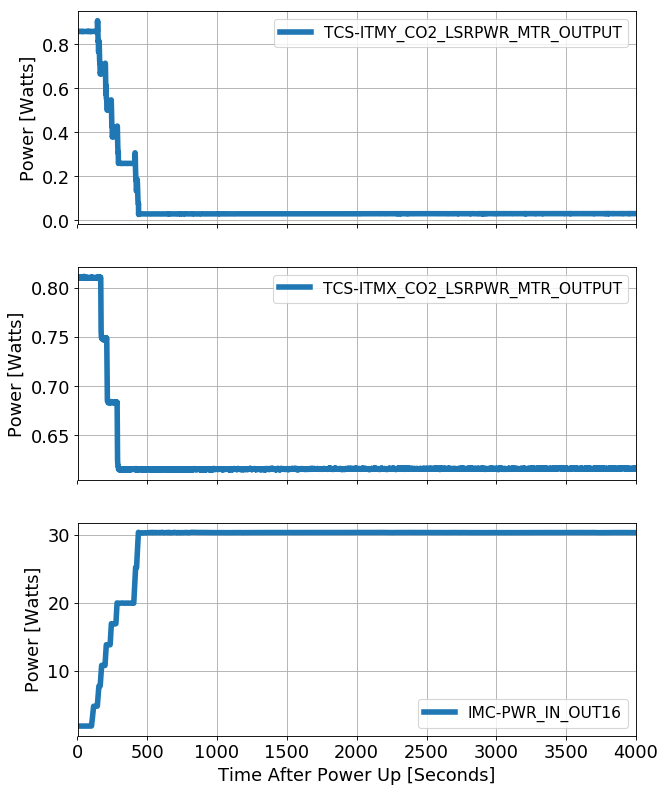

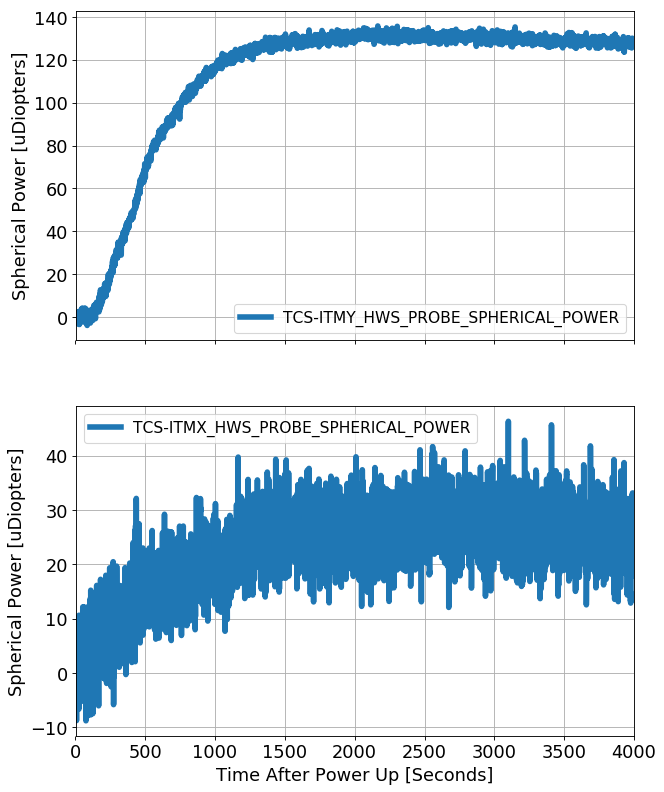

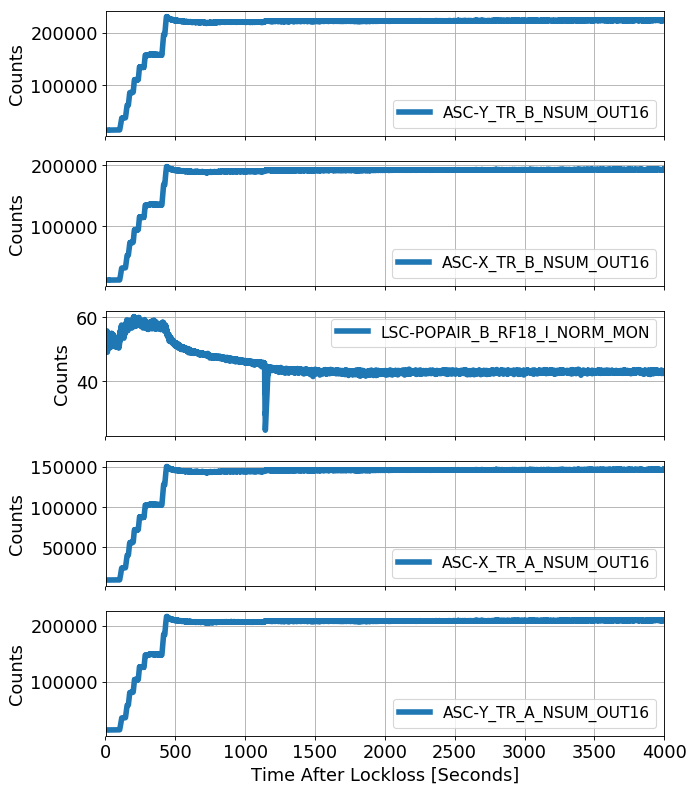

In [9]:
#### Plotting
def plot_ifo_data(ifo_dict,xlabel,ylabel,fname, scale_to_zero=False):
    fig = pl.figure(figsize=(9,12),dpi=80)
    
    for a,key,val in zip(enumerate(ifo_dict),ifo_dict.keys(),ifo_dict.values() ):
        ins = int(len(ifo_dict)*100 + 11 + a[0])
        ax1 = fig.add_subplot(ins)
        if scale_to_zero is True:
            avg = np.average(ifo_dict[key][10:20])
            ax1.plot(t_vect[10:-10],ifo_dict[key][10:-10]-avg,label=key,linewidth=5)
        else:
            ax1.plot(t_vect[10:-10],ifo_dict[key][10:-10],label=key,linewidth=5)
        ax1.grid()
        ax1.set_xlim([t_vect[10],t_vect[-10]])
        
        if a[0]+1 == len(ifo_dict):
            ax1.set_xlabel(xlabel,fontsize=16)
        else:
            pl.setp(ax1.get_xticklabels(), visible=False)
        ax1.set_ylabel(ylabel,fontsize=16)
        ax1.tick_params(labelsize=16)
        ax1.legend(fontsize=14)
        
    pl.savefig('/ligo/home/thomas.vo/TVo_Thesis/Figures/'+fname+'.png')
        
plot_ifo_data(pwr_dict,"Time After Power Up [Seconds]","Power [Watts]",
              fname=str(gps_start0)+"TCS_and_PSL_powerup")
plot_ifo_data(sph_dict,"Time After Power Up [Seconds]","Spherical Power [uDiopters]",
              fname=str(gps_start0)+"HWS_powerup",scale_to_zero=True)
plot_ifo_data(aux_dict,"Time After Lockloss [Seconds]","Counts",fname=str(gps_start0)+"AUX_powerup")

In [10]:
x_bp = get_bad_pixel_file('ITMX')
y_bp = get_bad_pixel_file('ITMY')

/h1hwsmsr/data/H1/BAD_PIXELS/ITMX.npy
/h1hwsmsr/data/H1/BAD_PIXELS/ITMY.npy


In [58]:
avg = np.average(sph_dict['TCS-ITMX_HWS_PROBE_SPHERICAL_POWER'][10:20])
x_sc = sph_dict['TCS-ITMX_HWS_PROBE_SPHERICAL_POWER']-avg

avg = np.average(sph_dict['TCS-ITMY_HWS_PROBE_SPHERICAL_POWER'][10:20])
y_sc = (sph_dict['TCS-ITMY_HWS_PROBE_SPHERICAL_POWER']-avg)/3
diff = y_sc - x_sc

avg = np.average(aux_dict['LSC-POPAIR_B_RF18_I_NORM_MON'][10:30])
pop_sc = aux_dict['LSC-POPAIR_B_RF18_I_NORM_MON']/aux_dict['LSC-POPAIR_B_RF18_I_NORM_MON'][10]

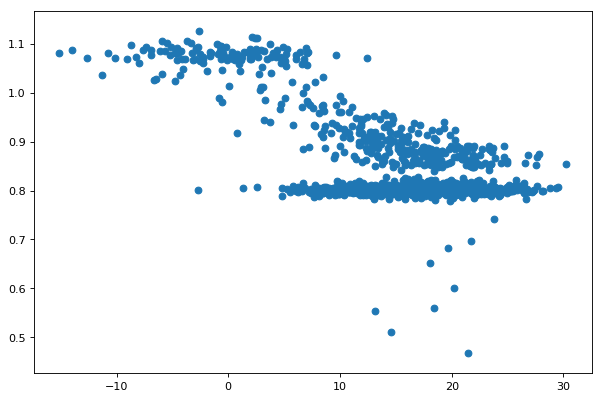

In [61]:
fig = pl.figure(figsize=(9,6),dpi=80)

pl.scatter(diff[500:-10:10],pop_sc[500:-10:10])

In [11]:
#User input origins, default is 511.5

a0 = 580.5
b0 = 490.5
c0 = 550.5
d0 = 511.5

x_origin = [a0,b0]
y_origin = [c0,d0]

In [12]:
#Load HWS Data directory
subprocess.call('hwsdata')
hws_data_dir = '/h1hwsmsr/data'

In [13]:
def initialize_graphing():
    """
    Mostly Formatting for matplotlib
    
    Parameters
    =======
    None
    
    Returns
    =======
    None
    
    """
    
    fig = pl.figure(figsize=(32,14),dpi=80)

    ax1 = fig.add_subplot(121)
    ax1.set_xlim([-0.17, 0.17])
    ax1.set_ylim([-0.17, 0.17])
    
    ax1.set_xlabel('ITM Coordinate [m]',fontsize=30)
    ax1.set_ylabel('ITM Coordinate [m]',fontsize=30)

    ax1.tick_params(axis='both', which='major', labelsize=26)
    
    ax1.grid()

    acir1, = ax1.plot([], [], 'b-', linewidth=1)
    acir2, = ax1.plot([], [], 'b-', linewidth=1)

    ax2= fig.add_subplot(122)

    ax2.set_xlim([-0.17, 0.17])
    ax2.set_ylim([-0.17, 0.17])
    
    ax2.set_xlabel('ITM Coordinate [m]',fontsize=30)
    ax2.tick_params(axis='both', which='major', labelsize=26)
    
    ax2.grid()

    bcir1, = ax2.plot([], [], 'b-', linewidth=1)
    bcir2, = ax2.plot([], [], 'b-', linewidth=1)
    
    # Make the ITM circle
    cir1, = ax2.plot([], [], 'b-', linewidth=1)
    cir2, = ax2.plot([], [], 'b-', linewidth=1)
    
    theta = np.arange(-np.pi/200, 2*np.pi, np.pi/200)
    xITM = 0.17*np.cos(theta)
    yITM = 0.17*np.sin(theta)
    indEdge = np.where(abs(xITM) > 326.5E-3/2)
    xITM[indEdge] = np.sign(xITM[indEdge])*326.5E-3/2
    cir1.set_data(xITM, yITM)

    xITM = 0.1686 * np.cos(theta)
    yITM = 0.1686 * np.sin(theta)
    indEdge = np.where(abs(xITM) > 326.5E-3/2 - 1.41E-3)
    xITM[indEdge] = np.sign(xITM[indEdge])*(326.5E-3/2-1.41E-3)
    cir2.set_data(xITM, yITM)
    
    return fig, [ax1,ax2]

def plot_wf_quiver(fig,axes,c_range, wfs_in, cents, U, V, x_g, y_g, dur, fname, origin=None):
    """
    Plot the quiver map and the wavefront map
    
    """
    
    ax1=axes[0]
    ax2=axes[1]
    
    pixel_size = 12e-6
    pixel_number = 1024
    magnification = 17.5

    rng = 1000*pixel_size*magnification/pixel_number

    ax1.quiver((cents[:,0]-pixel_number/2)*rng, (cents[:,1]-pixel_number/2)*rng, U, V, units='x')
    
    ax1.text(0, 0.15, 't = '+str(dur)+ ' seconds after power up',
         {'color': 'k', 'fontsize': 35, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="w", ec="k", pad=0.2)})
    
    img0= ax2.contourf(x_g,y_g,wfs_in,c_range,cmap='plasma')
    
    cb_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(img0,cax=cb_ax)
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label('Optical Path Distortion [nm]',fontsize=30, labelpad=10)
    
    img1= ax2.contour(x_g,y_g,wfs_in, colors='k', linewidths=1.25,linestyles='solid')
    
    if origin:
        img2= ax2.plot( (origin[0]-pixel_number/2)*rng, (origin[1]-pixel_number/2)*rng, 'X', markersize=18)
    
    pl.savefig('/ligo/home/thomas.vo/TVo_Thesis/Figures/'+fname+'.png')

Spherical power is -1.507791547355017 udiopters
Spherical power is 13.79297772764715 udiopters


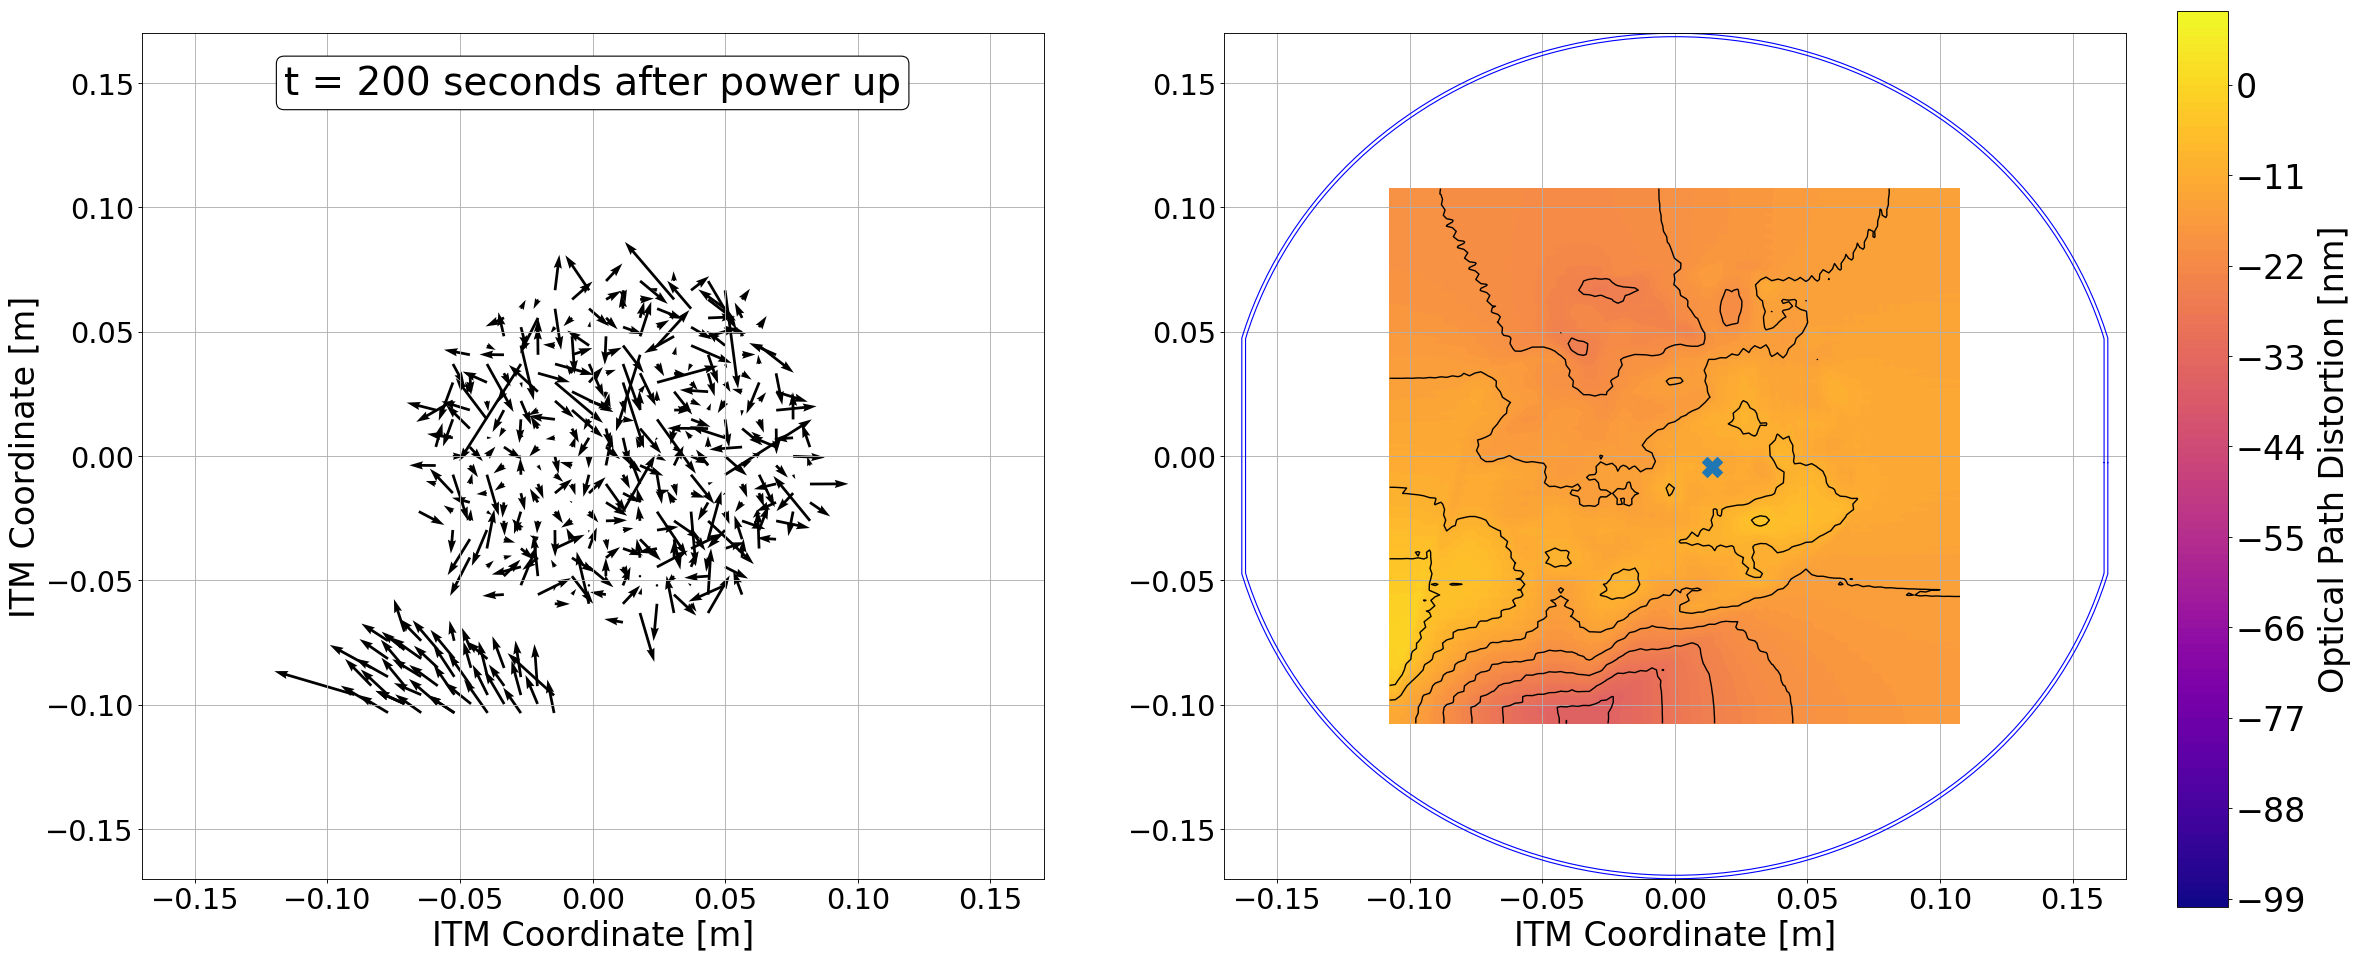

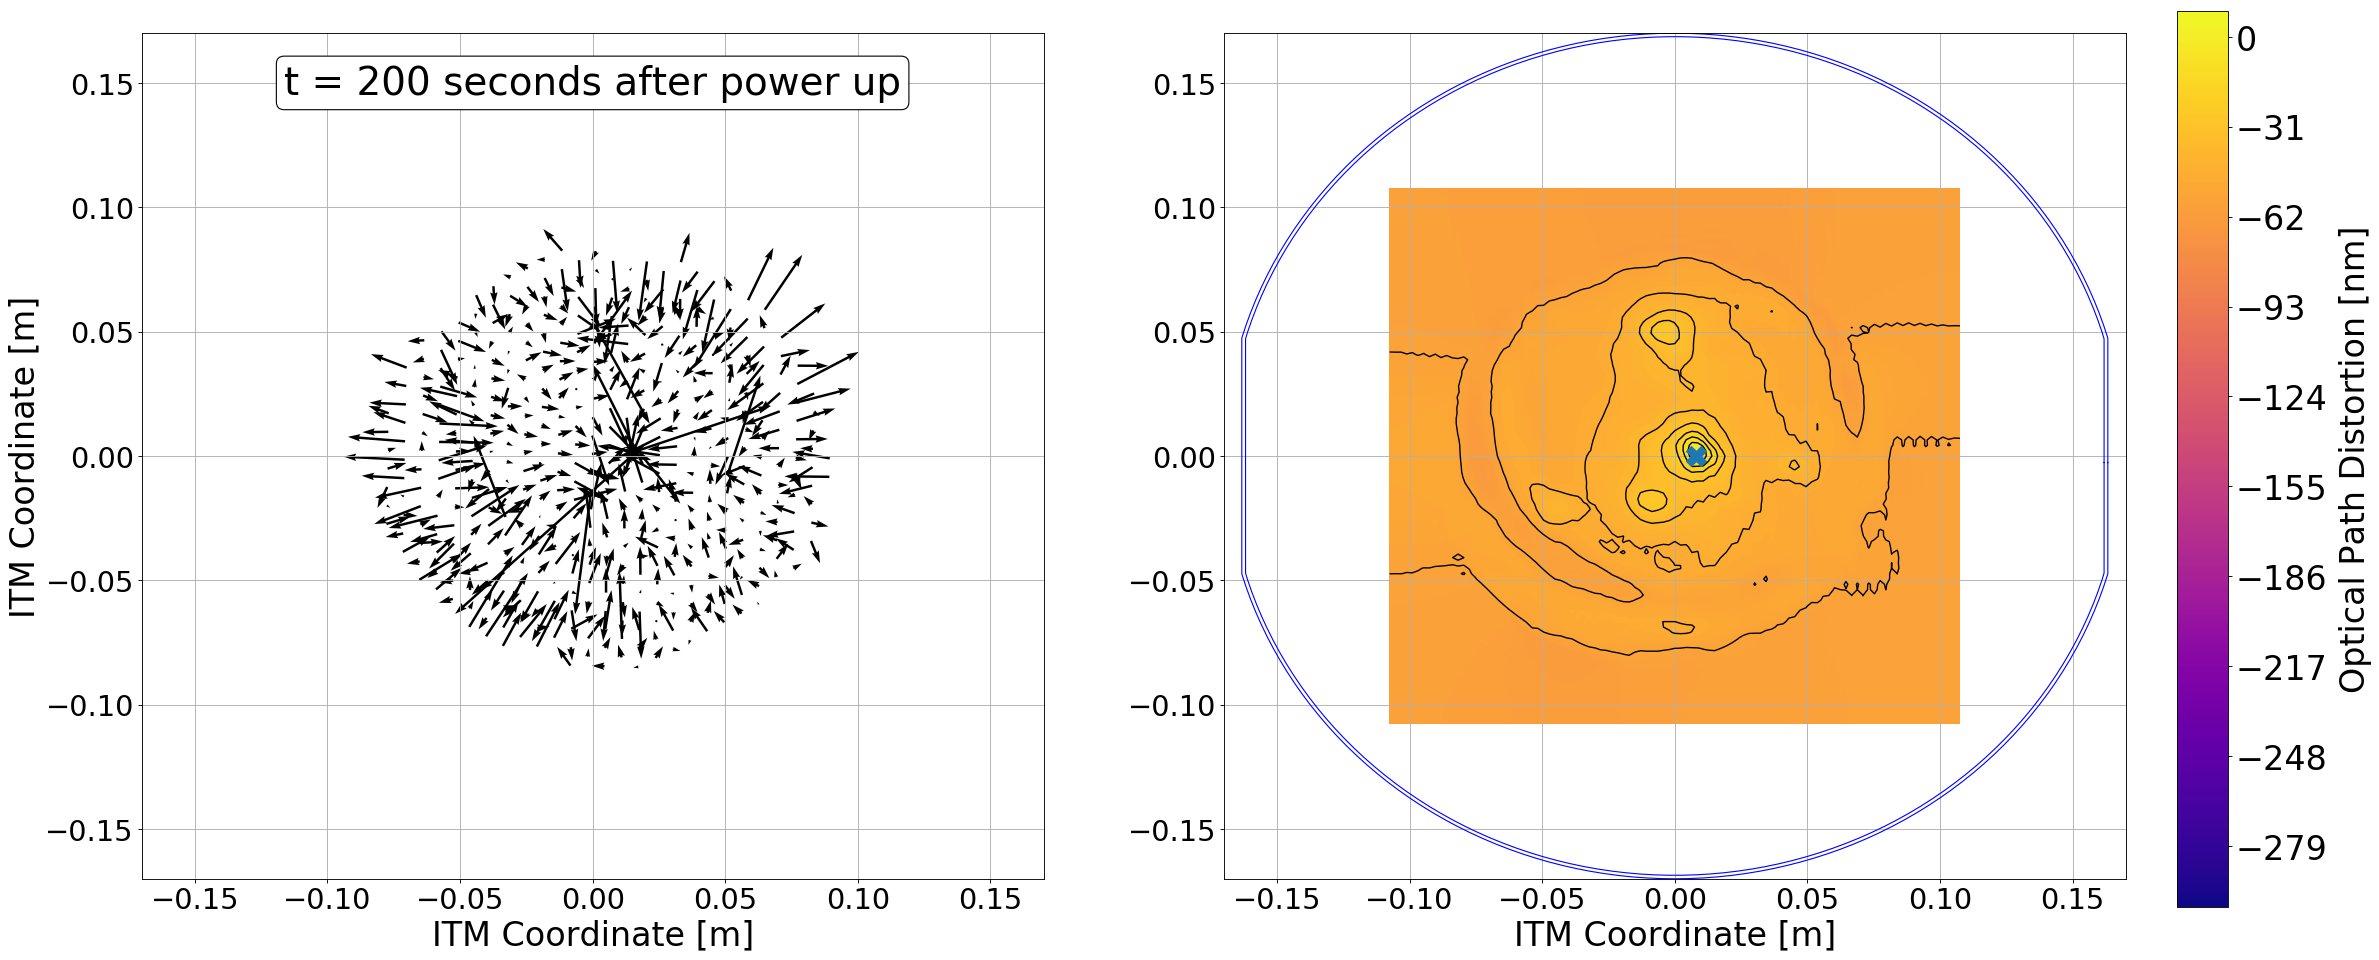

In [14]:
d = 200
make_plots(gps_start0,d,str(gps_start0)+'_'+str(d)+'dur_30W_ITM')

Spherical power is 10.84492102927857 udiopters
Spherical power is 72.57650182908091 udiopters


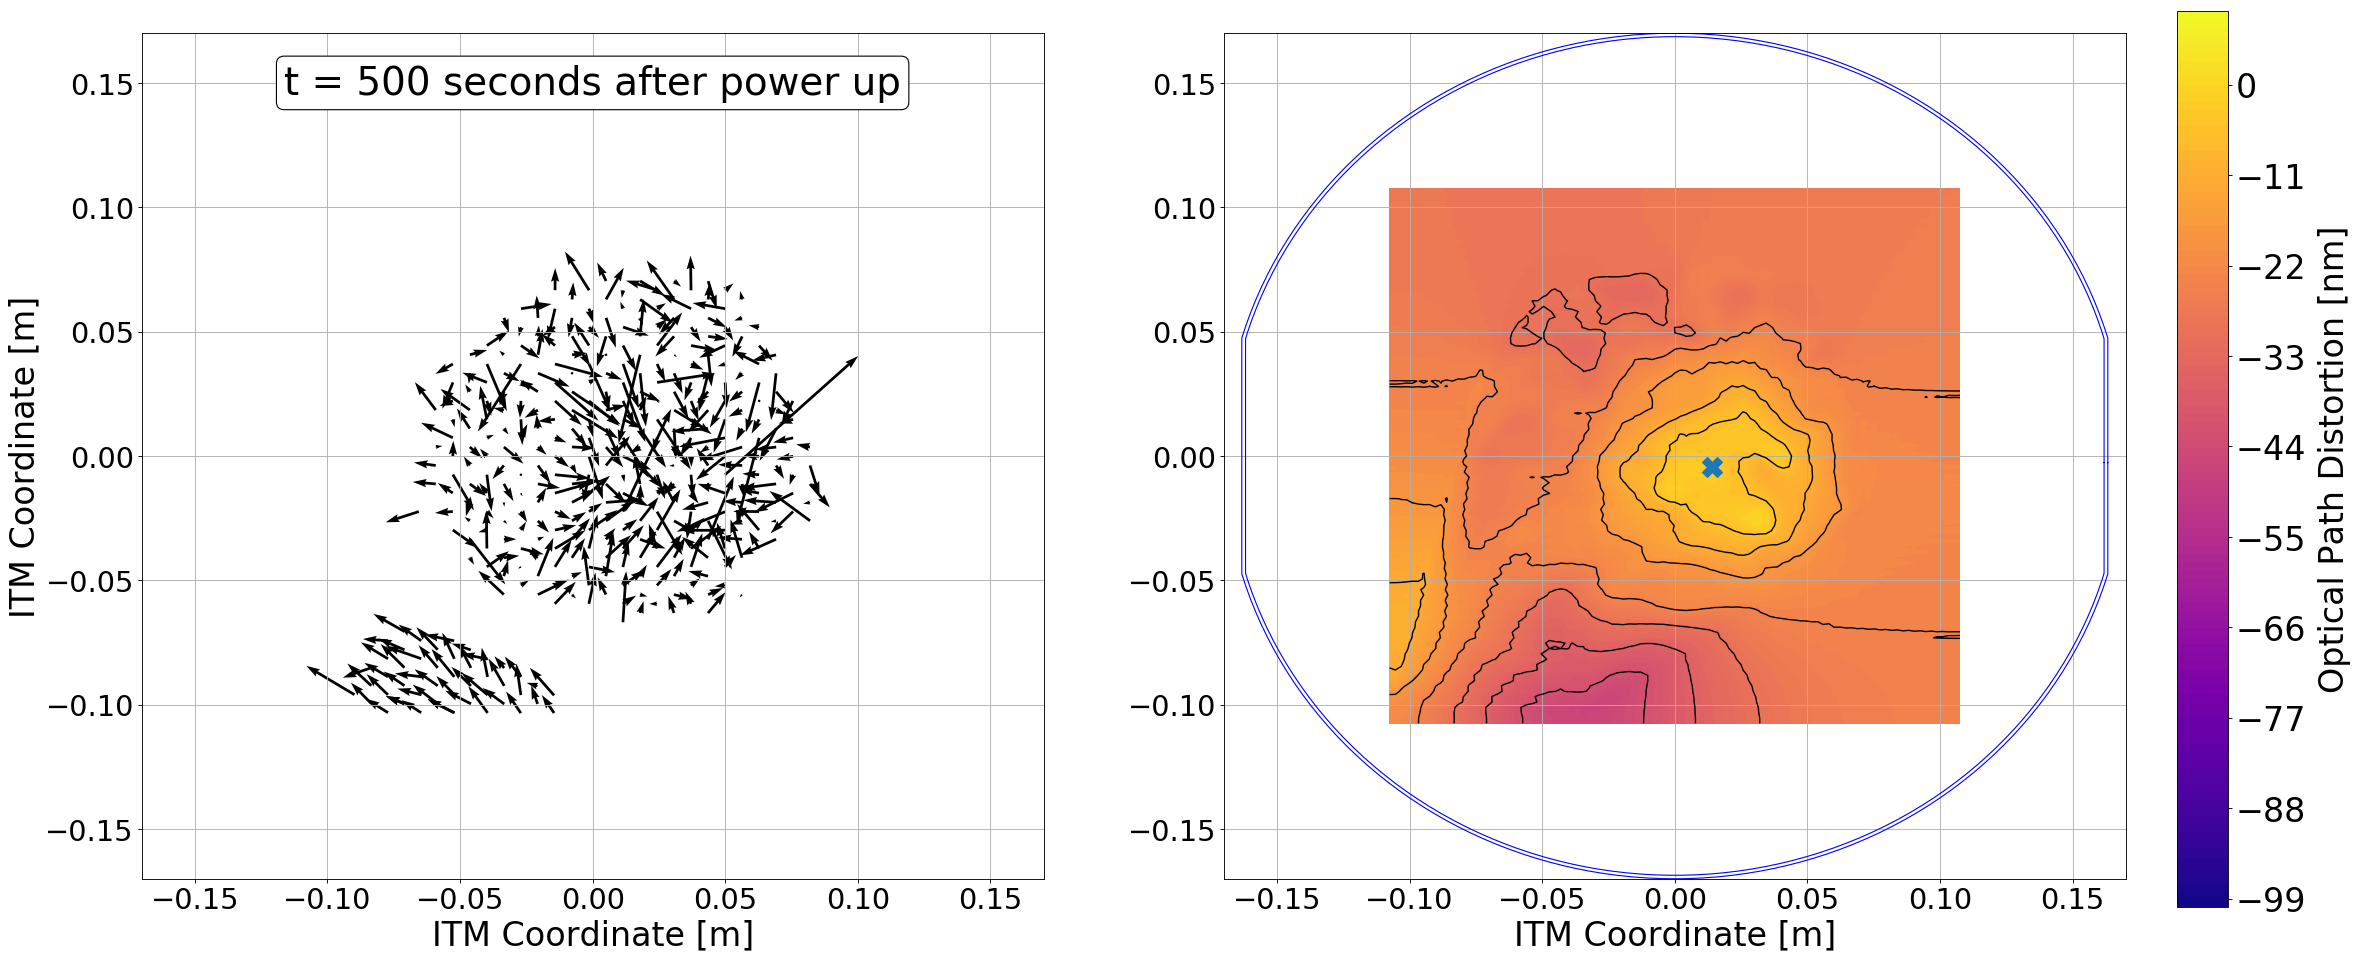

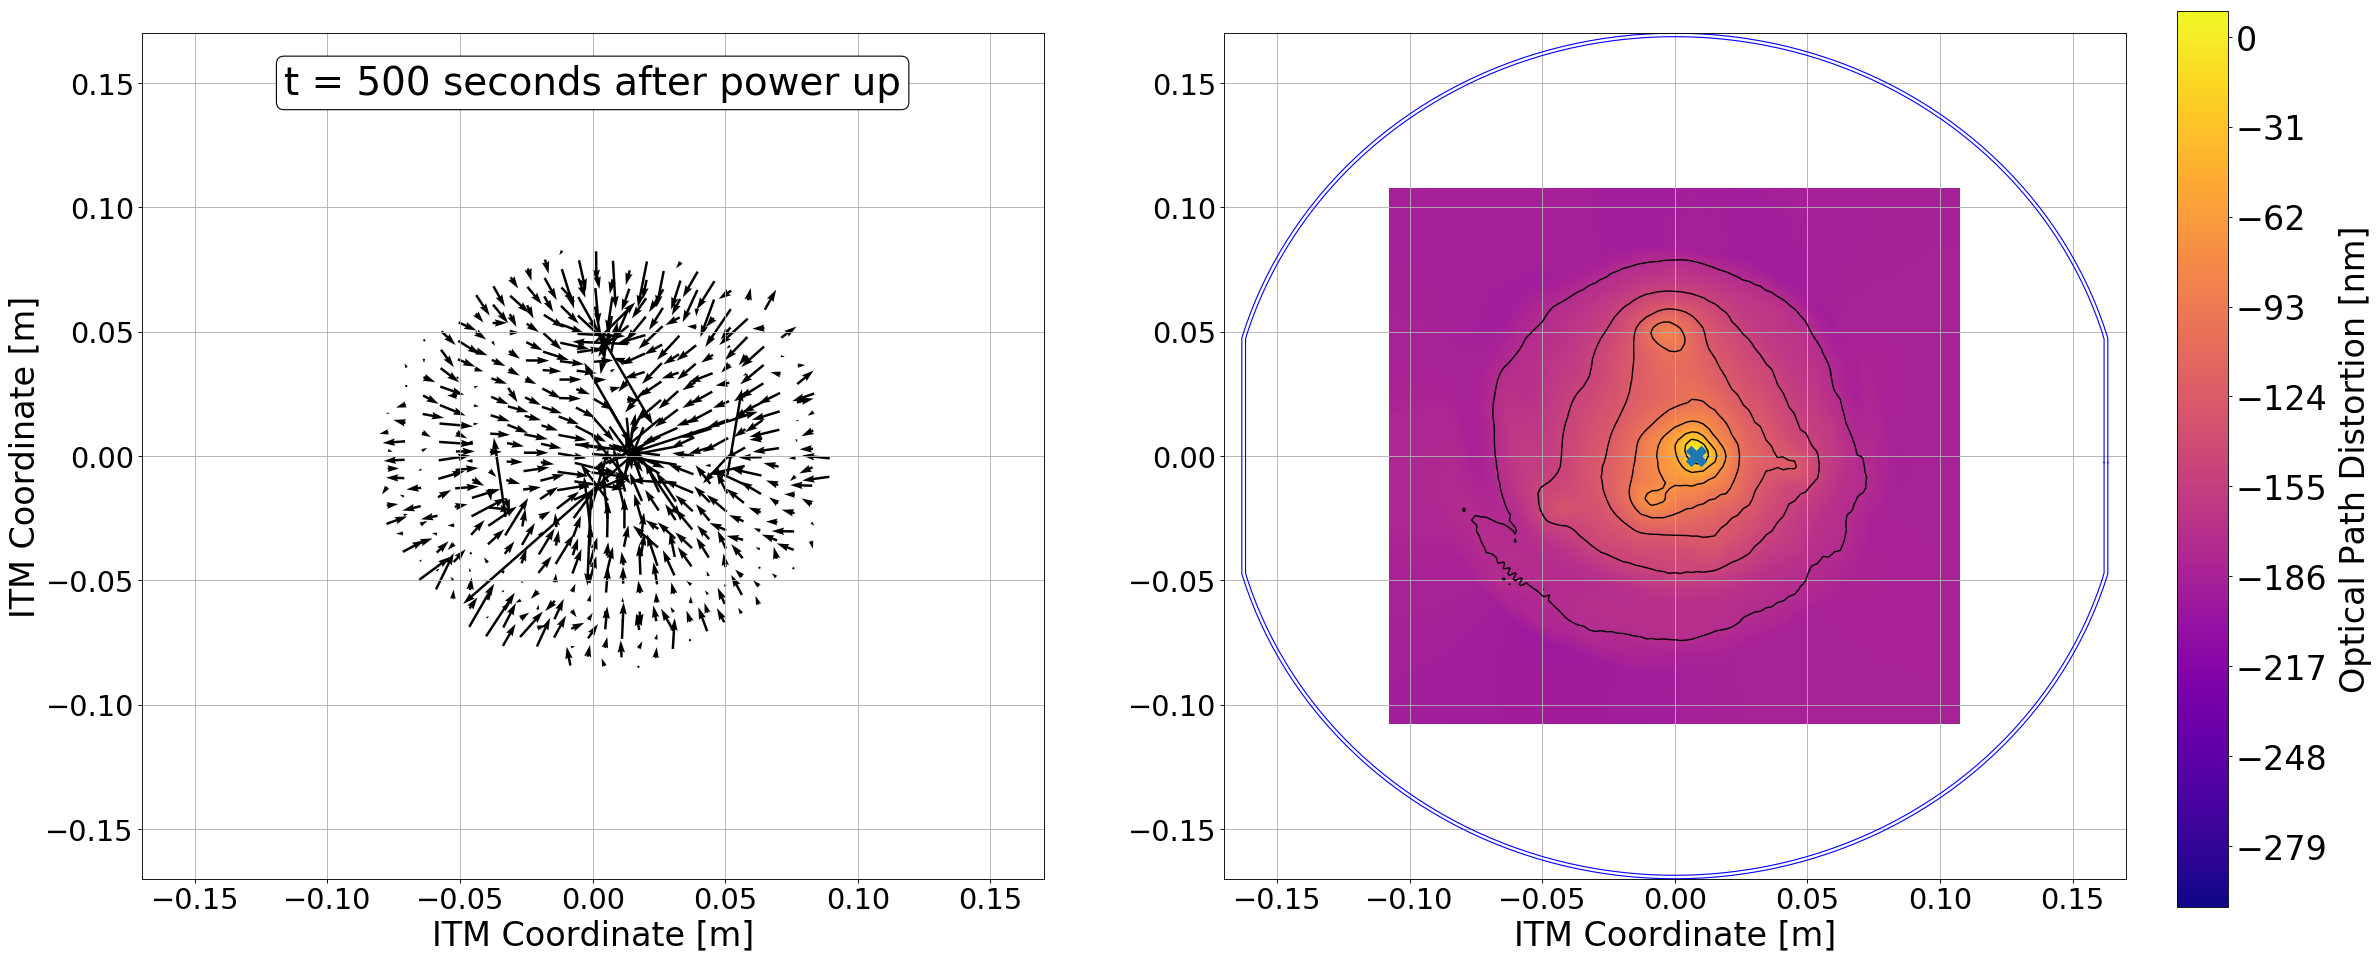

In [15]:
d = 500
make_plots(gps_start0,d,str(gps_start0)+'_'+str(d)+'dur_30W_ITM')

Spherical power is 19.577770111937205 udiopters
Spherical power is 114.77715979484637 udiopters


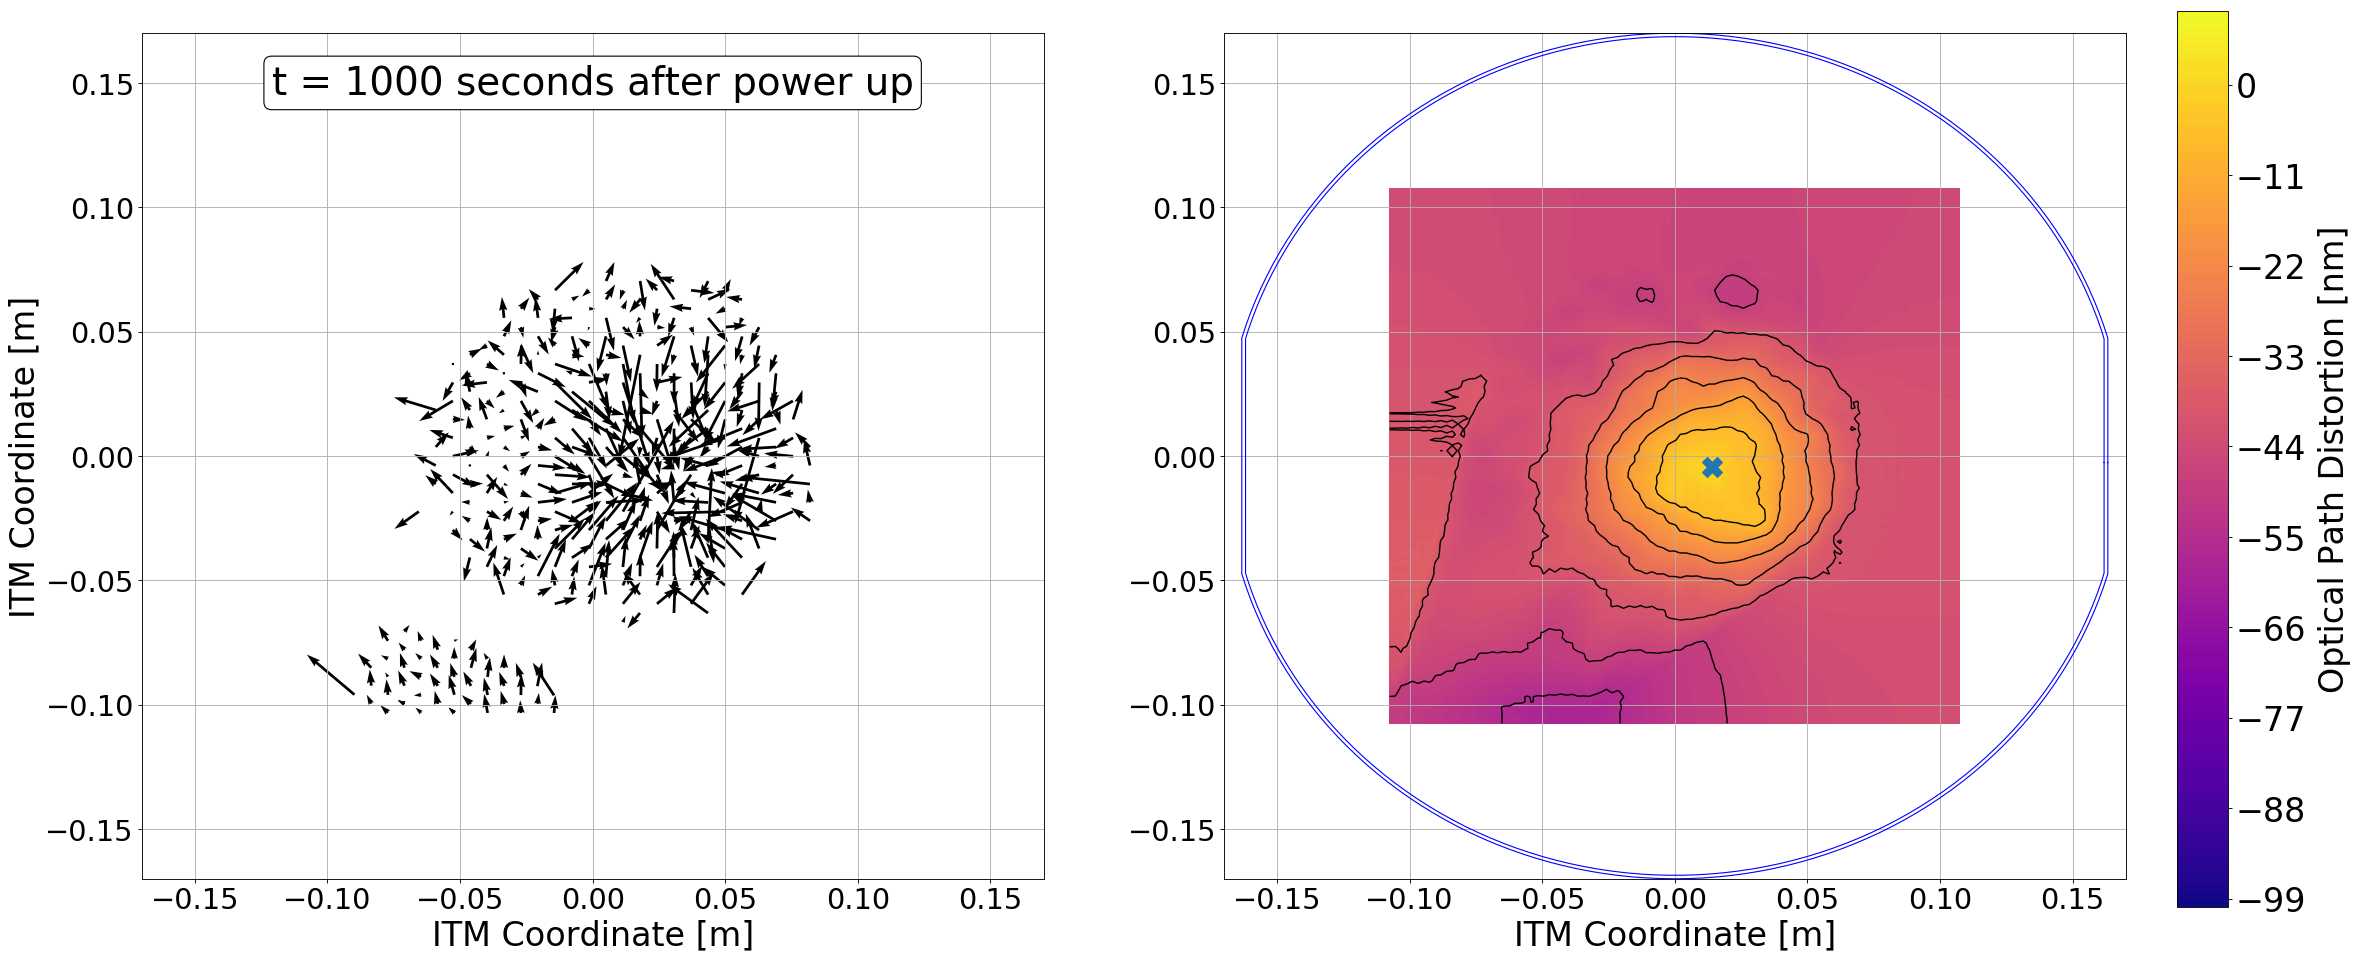

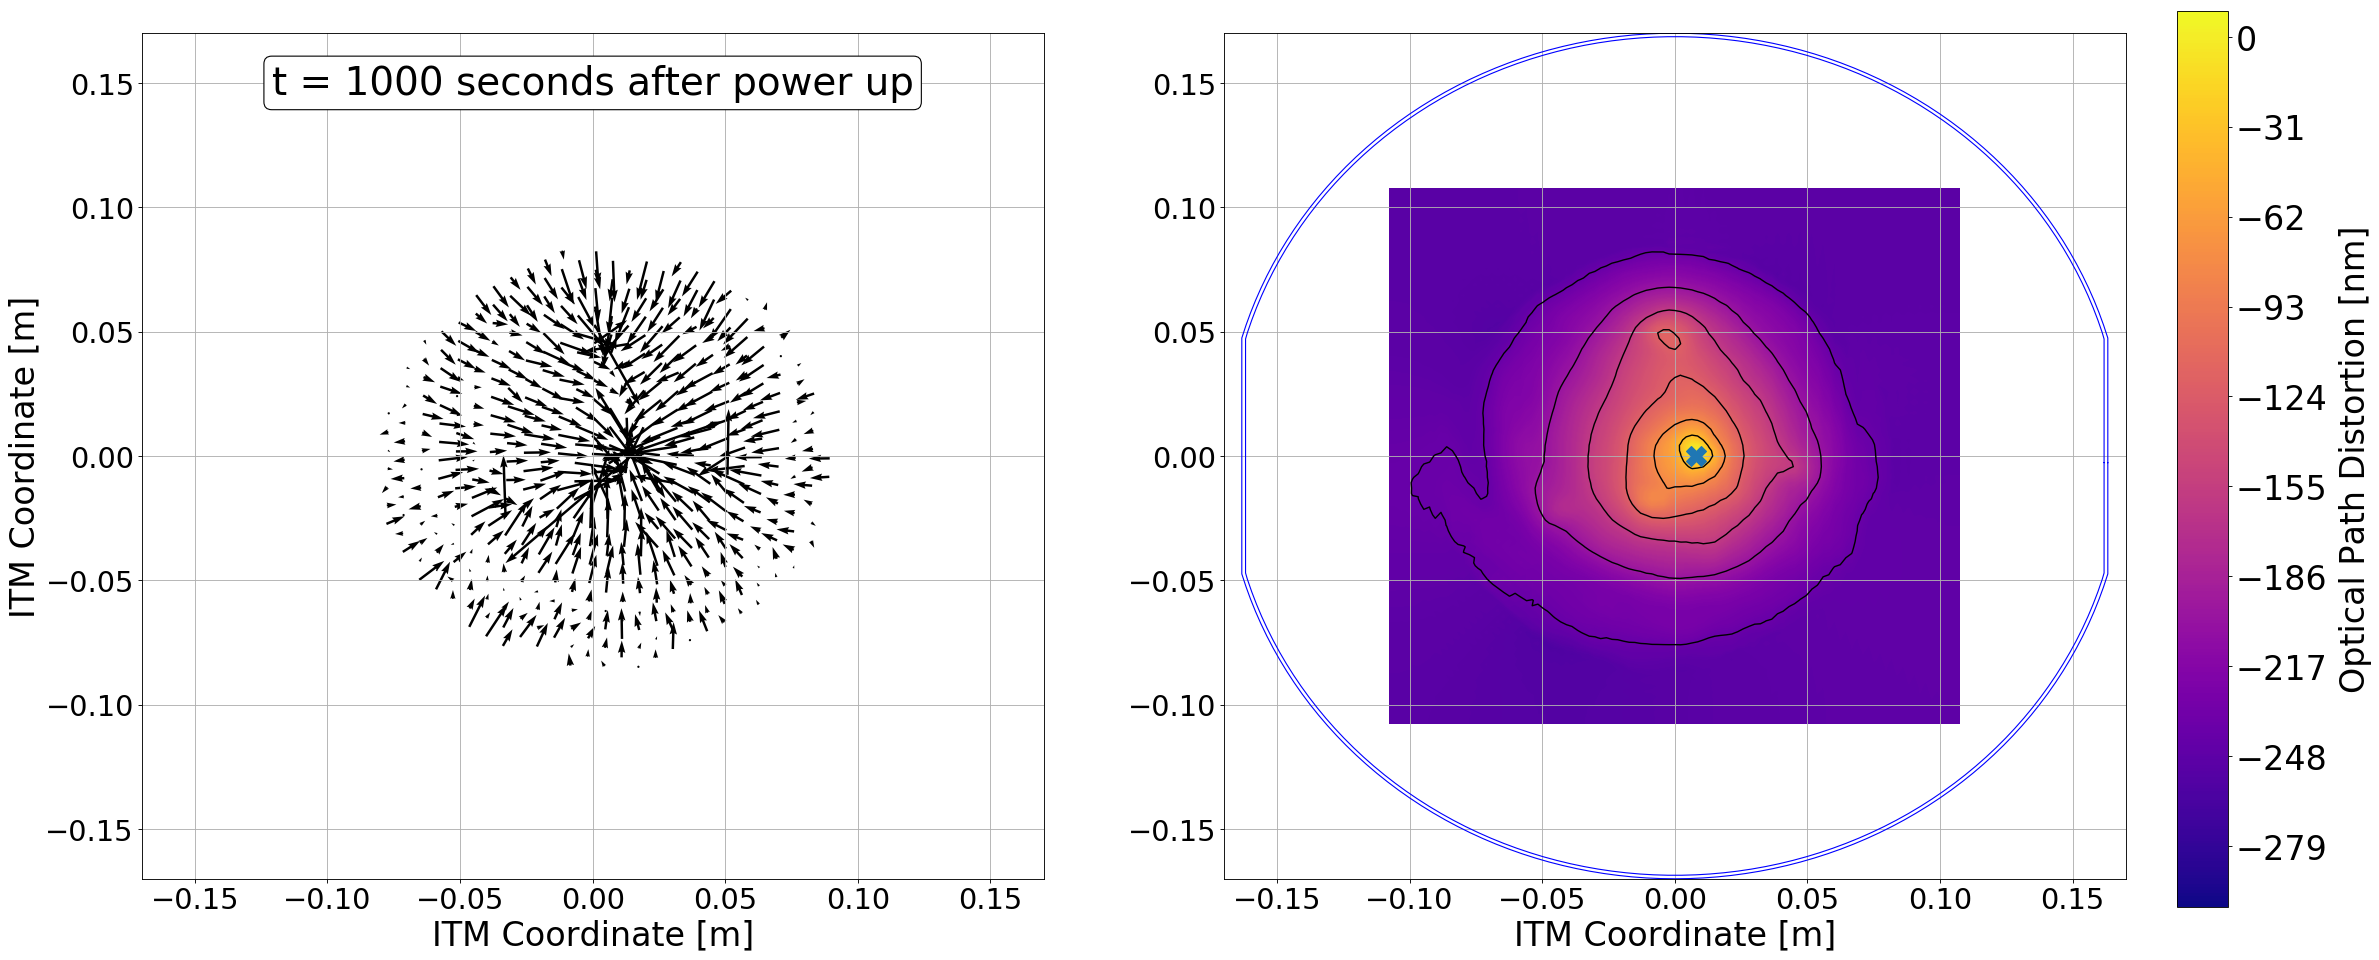

In [16]:
d = 1000
make_plots(gps_start0,d,str(gps_start0)+'_'+str(d)+'dur_30W_ITM')

Spherical power is 28.765165168475068 udiopters
Spherical power is 123.02911783815655 udiopters


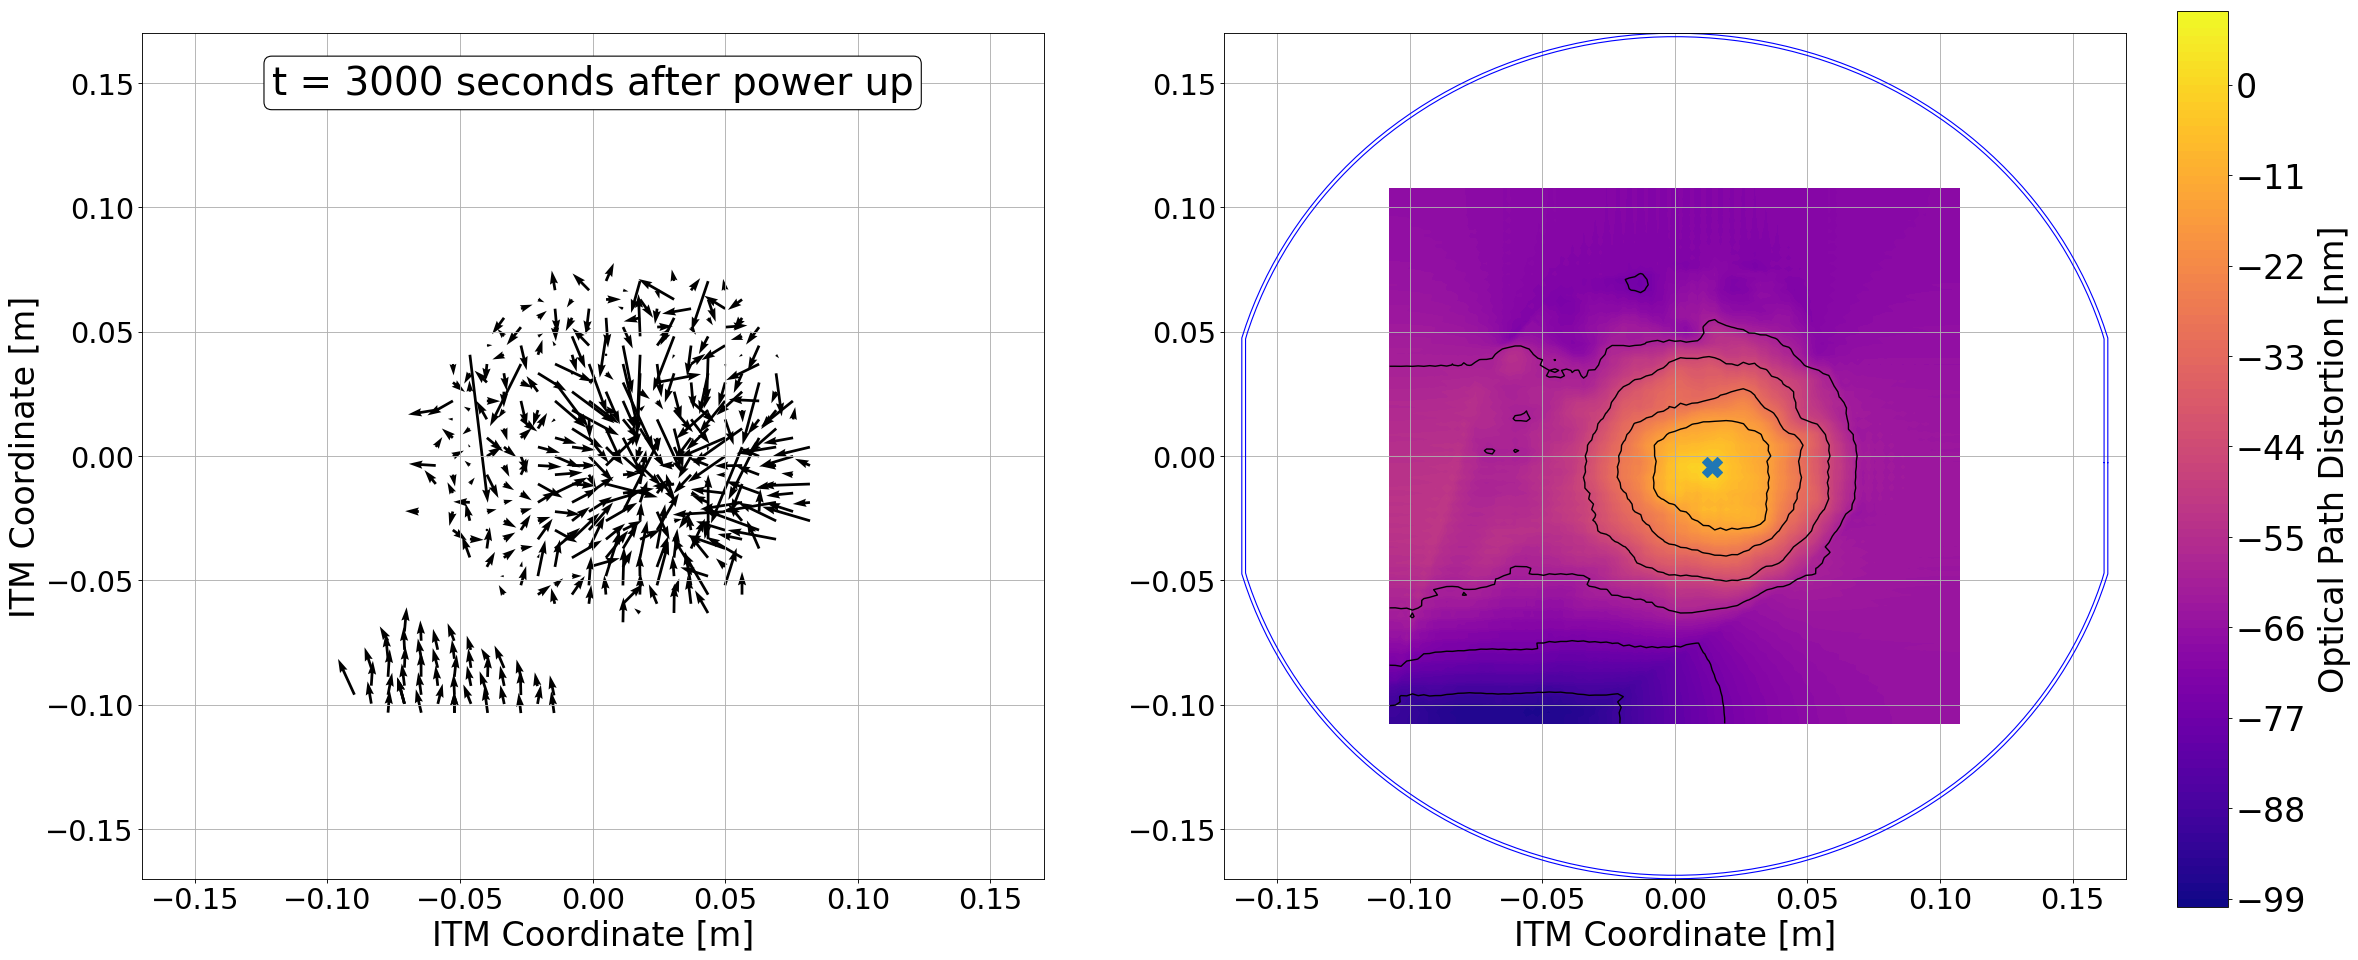

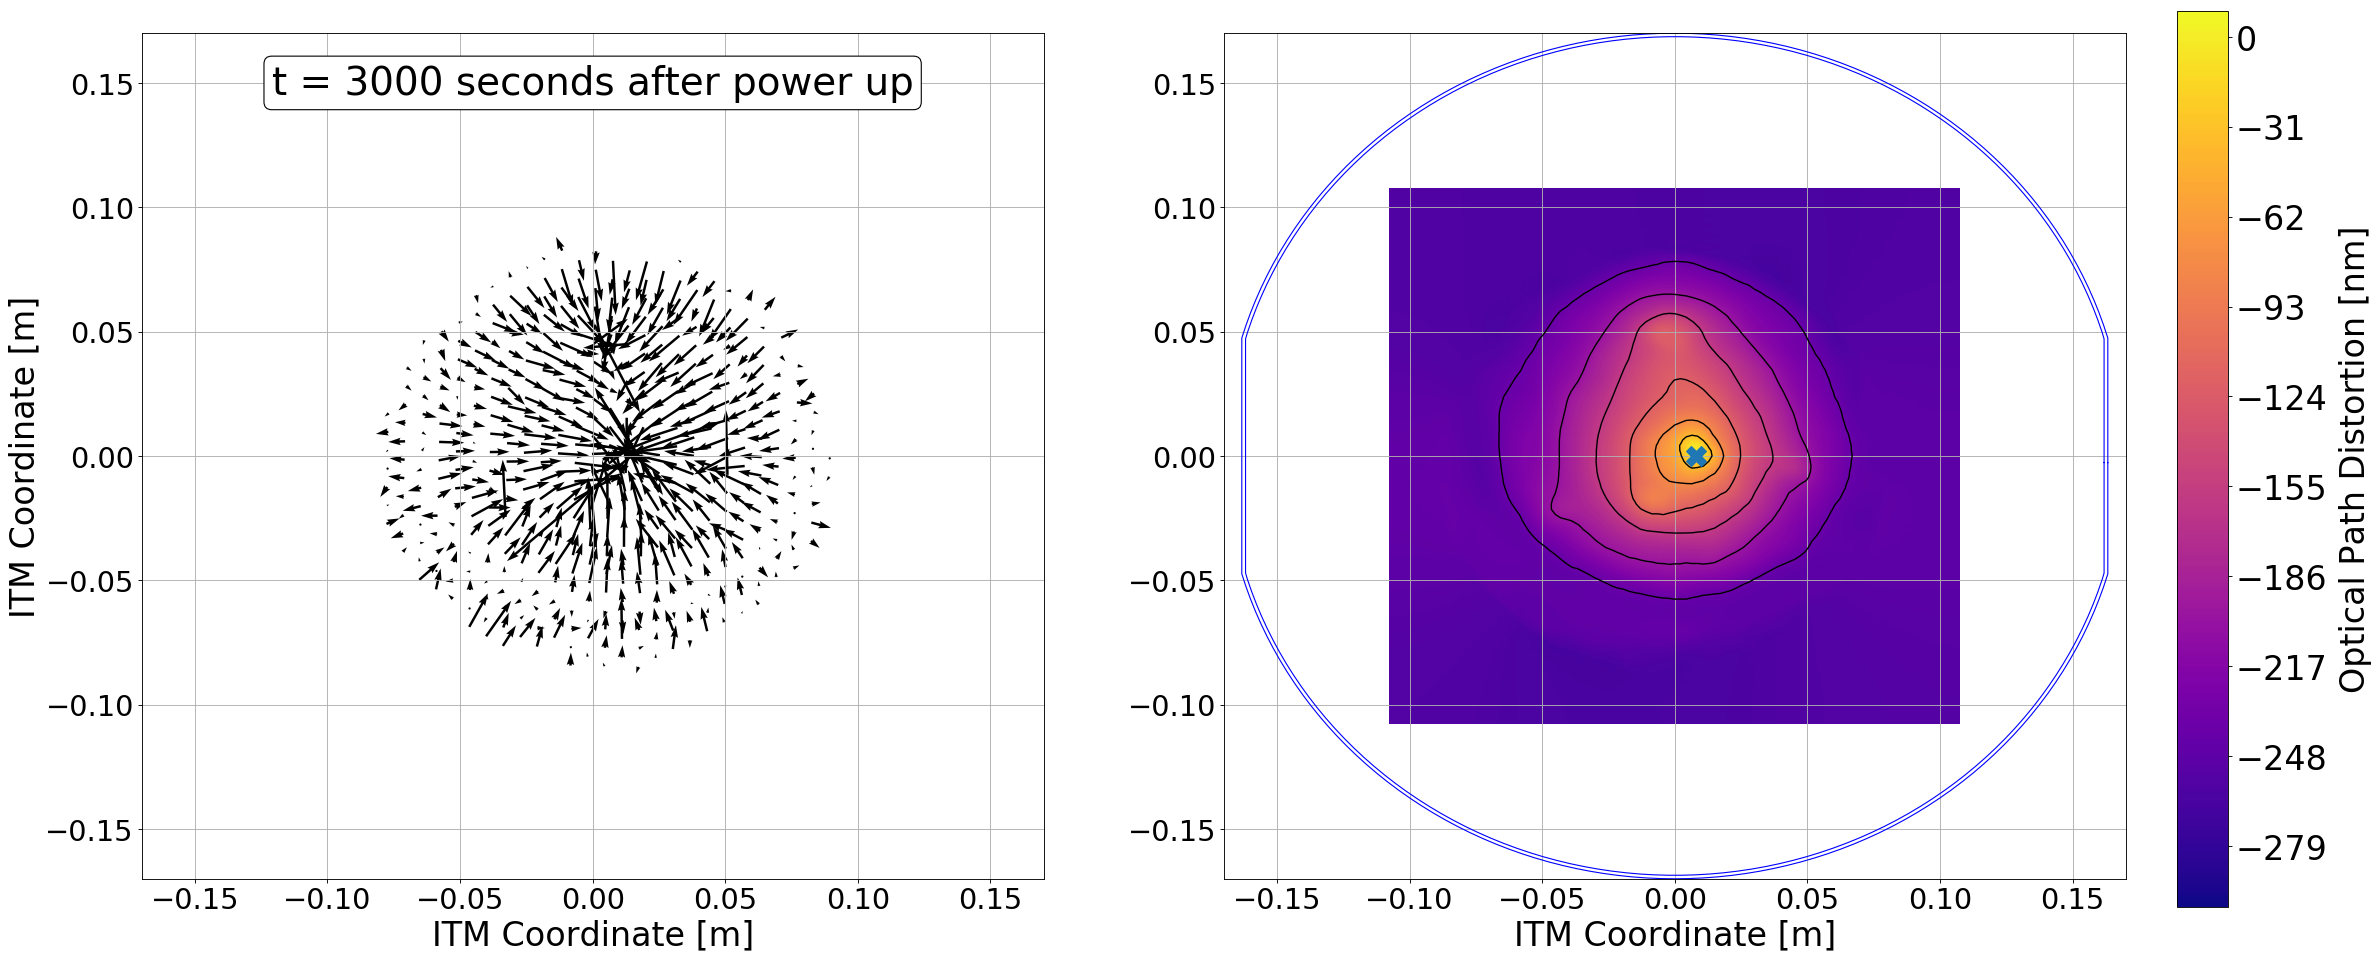

In [17]:
d = 3000
make_plots(gps_start0,d,str(gps_start0)+'_'+str(d)+'dur_30W_ITM')

In [18]:
def make_3dplots(t0,dur,filename):
    x_wf, x_cent, x_grad, x_U, x_V, x_xg, x_yg = get_hws_data('ITMX',
                                                        t0, 
                                                        t0+dur, 
                                                        x_bp,
                                                        origin = x_origin)

    y_wf, y_cent, y_grad, y_U, y_V, y_xg, y_yg = get_hws_data('ITMY', 
                                                        t0, 
                                                        t0+dur, 
                                                        y_bp,
                                                        origin = y_origin) 

    x_seidls = get_seidel(x_grad)
    print("Spherical power is " + str(x_seidls['spherical_power']*1e6) + " udiopters")

    y_seidls = get_seidel(y_grad)
    print("Spherical power is " + str(y_seidls['spherical_power']*1e6) + " udiopters")

    #### Plotting
    # %matplotlib notebook
    # use notebook to tune the azim and elev and plots
    
    fig = pl.figure(figsize=(15,7),dpi=100)
    fig.suptitle('t = ' + str(dur) + ' seconds', fontsize = 25, y = 0.80)
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    
    ax.set_zlim(-300, 10)
    
    ax.set_xlabel('ITMX Coordinate [m]',fontsize=16,labelpad=20)
    ax.set_ylabel('ITMX Coordinate [m]',fontsize=16,labelpad=20)
    ax.set_zlabel('OPD [nm]',fontsize=16,labelpad=20)
    
    ax.dist = 13
    
    ax.tick_params(labelsize=12)
    
    ax.azim = -39
    ax.elev =  30

    surf = ax.plot_surface(x_xg, x_yg, x_wf, cmap=cm.cool, linewidth=0, antialiased=False)
    
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    
    ax.set_zlim(-300, 10)
    
    ax.set_xlabel('ITMY Coordinate [m]',fontsize=16,labelpad=20)
    ax.set_ylabel('ITMY Coordinate [m]',fontsize=16,labelpad=20)
    ax.set_zlabel('OPD [nm]',fontsize=16,labelpad=20)
    
    ax.dist = 13
    
    ax.tick_params(labelsize=12)
    
    ax.azim = -39
    ax.elev =  30

    surf = ax.plot_surface(y_xg, y_yg, y_wf, cmap=cm.cool, linewidth=0, antialiased=False)
    
    pl.tight_layout()
    
    pl.savefig('/ligo/home/thomas.vo/TVo_Thesis/Figures/'+filename+'.png')

Spherical power is -1.507791547355017 udiopters
Spherical power is 13.79297772764715 udiopters


/ligo/cds/lho/h1/anaconda/anaconda2/lib/python2.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:120: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  self.axesPatch.set_linewidth(0)
/ligo/cds/lho/h1/anaconda/anaconda2/lib/python2.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:247: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  self.axesPatch.draw(renderer)


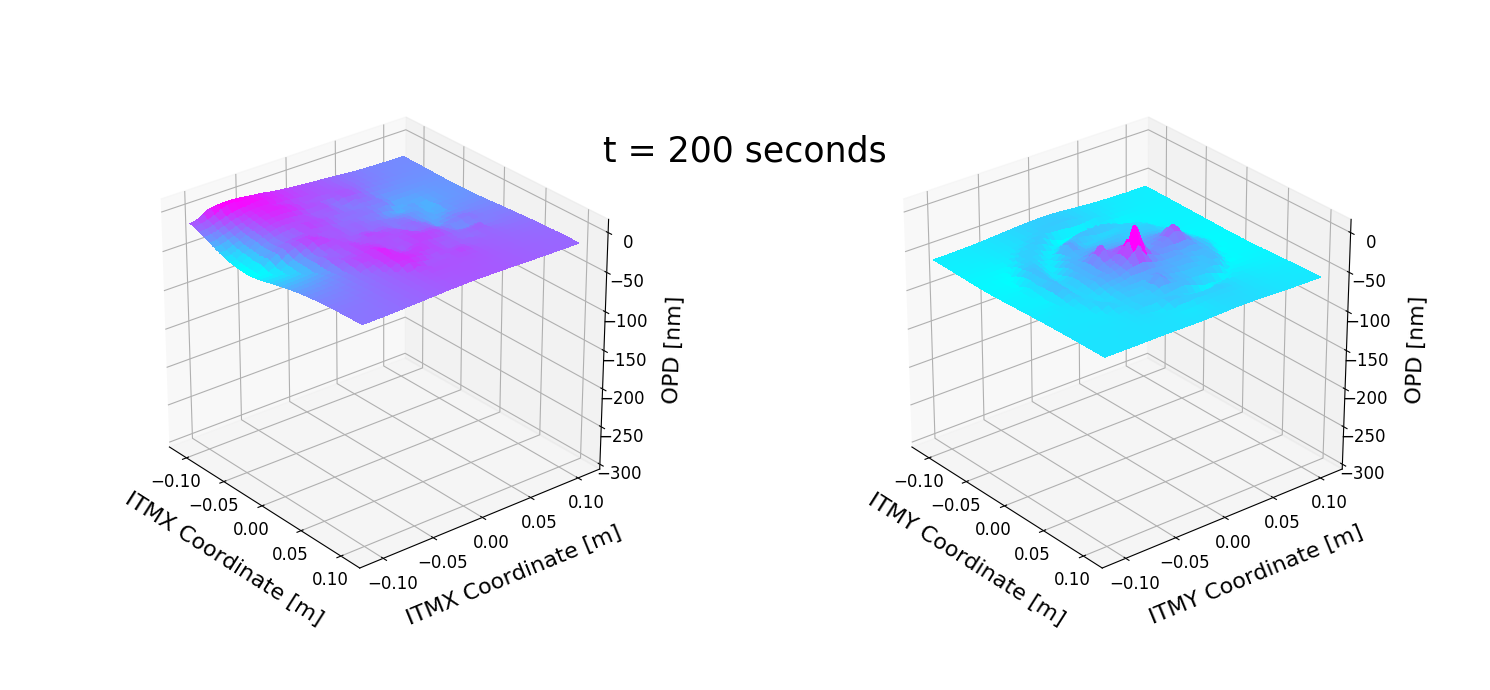

In [19]:
d = 200
make_3dplots(gps_start0,d,str(gps_start0)+'_3d_'+str(d)+'dur_30W_ITM')

Spherical power is 10.84492102927857 udiopters
Spherical power is 72.57650182908091 udiopters


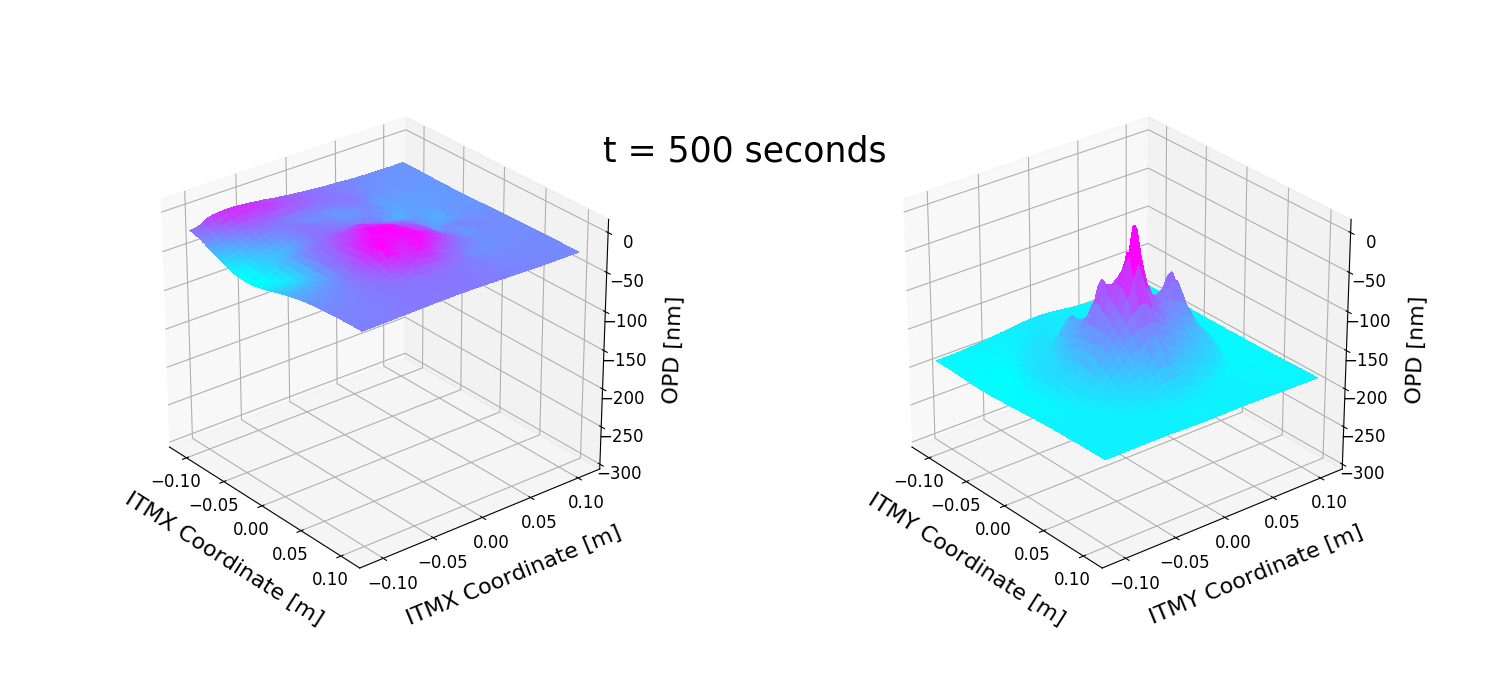

In [20]:
d = 500
make_3dplots(gps_start0,d,str(gps_start0)+'_3d_'+str(d)+'dur_30W_ITM')

Spherical power is 19.577770111937205 udiopters
Spherical power is 114.77715979484637 udiopters


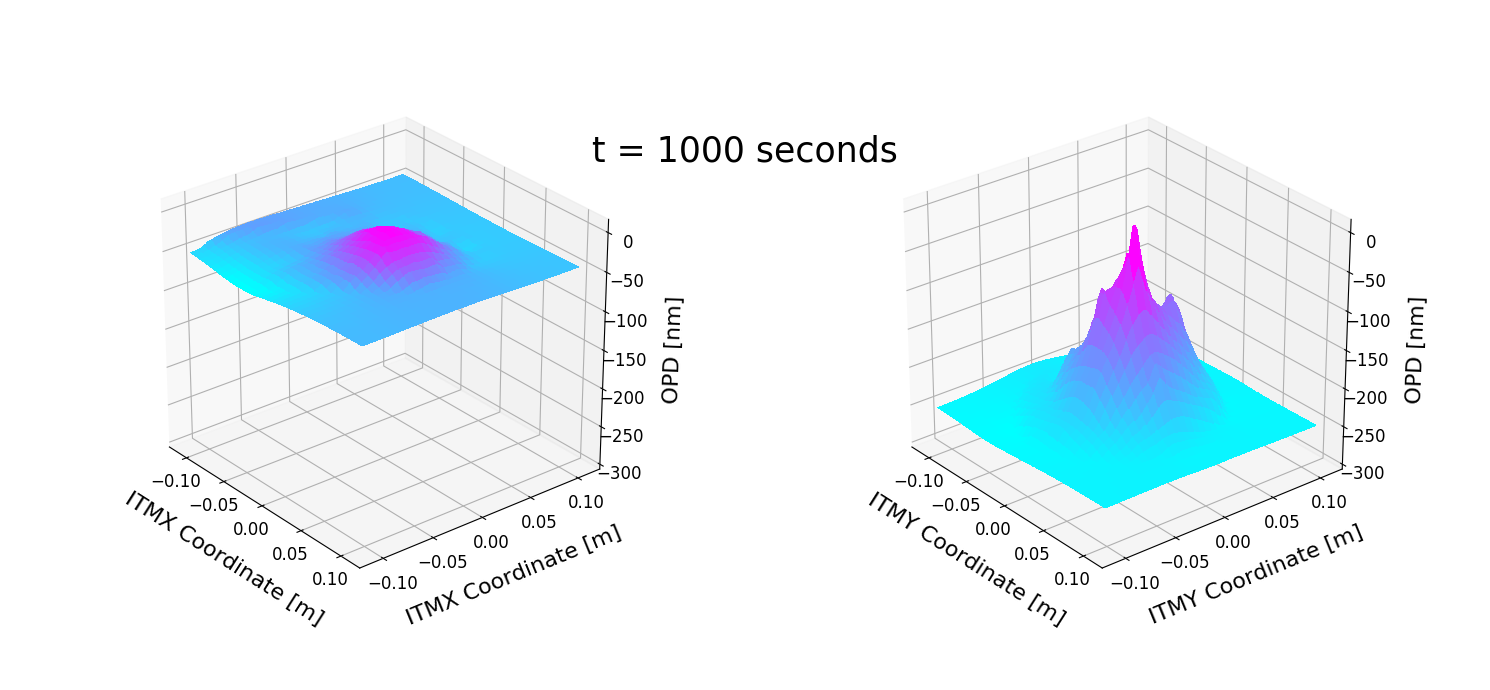

In [21]:
d = 1000
make_3dplots(gps_start0,d,str(gps_start0)+'_3d_'+str(d)+'dur_30W_ITM')

Spherical power is 28.765165168475068 udiopters
Spherical power is 123.02911783815655 udiopters


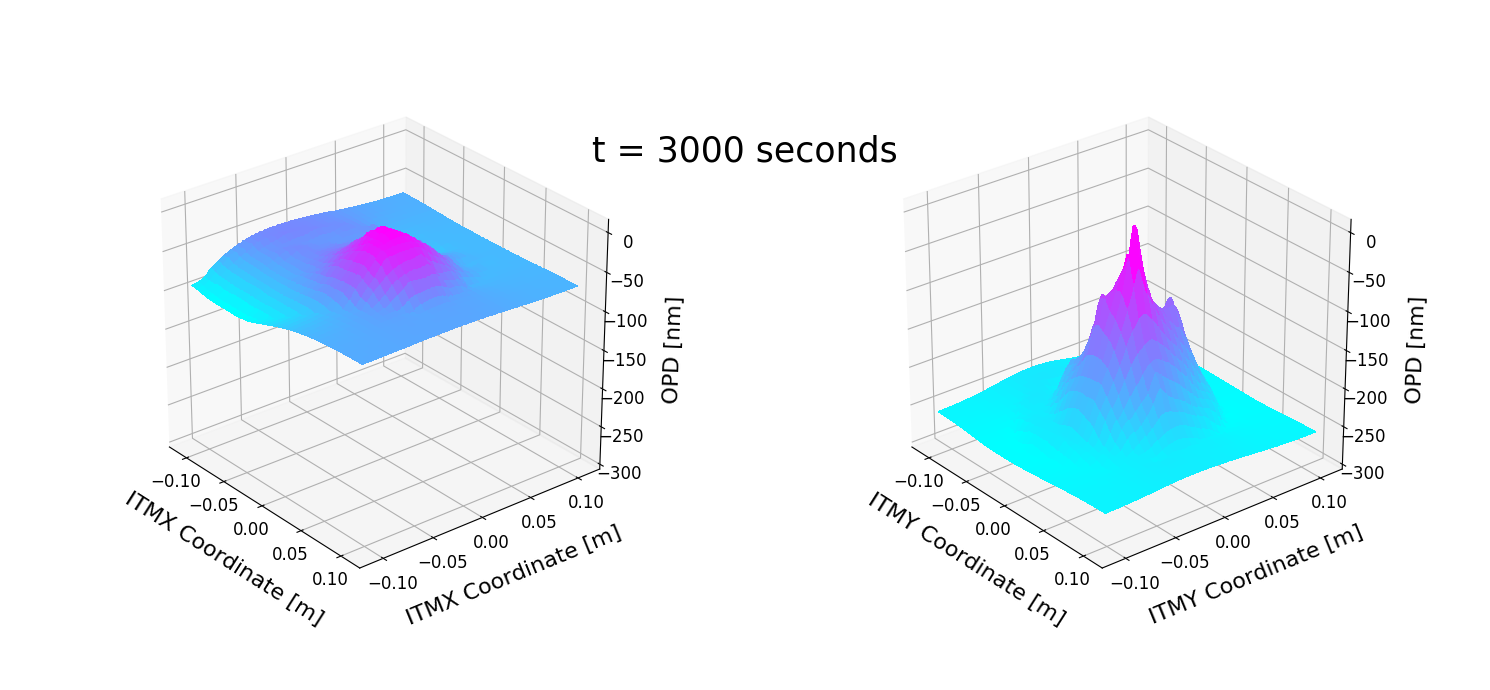

In [22]:
d = 3000
make_3dplots(gps_start0,d,str(gps_start0)+'_3d_'+str(d)+'dur_30W_ITM')